User Exercises

0:
K=1024
bplot=7
aplot=250

1:
K=64
bplot=7
aplot=250

2:
K=6400
bplot=7
aplot=250

3:
K=1024
bplot=7
aplot=120

4:
K=64
bplot=7
aplot=120

5:
K=1024
bplot=7
aplot=180

In [1]:
##USERS CHANGE THESE PARAMETERS

#number of pulses integrated (Note 6400 is the maximum in a single file)
K=1024

#beam to plot
bplot=7

#altitude to plot in km
aplot=250

In [2]:
import numpy
import matplotlib.pyplot as plt
import scipy.fftpack as fftp

In [3]:
# Download the data file that we need to run these examples
import os
outputfilepath='./d0045400.dt3.h5'
if not os.path.exists(outputfilepath):
    import urllib.request
    url='https://data.amisr.com/database/tmp/isr_school_2020/d0045400.dt3.h5'

    print('Downloading data file...')
    urllib.request.urlretrieve(url,outputfilepath)

    print('...Done!')

In [4]:
print(os.path.exists(outputfilepath))

True


In [5]:
#Load an example file
import io_utils #wrapper for pytables routines

#This is one file from a WorldDay35 experiment
f=io_utils.read_whole_h5file(outputfilepath)


rng=f['/S/Data/Acf']['Range'][0,:]*1e-3 #km
lag=f['/S/Data/Acf']['Lags'][0,:]*1e6 #us

#padding tricks to get pcolormesh to actually plot the whole array
rng=numpy.concatenate((rng,numpy.array([rng[-1]+rng[-1]-rng[-2]])))
lag=numpy.concatenate((lag,numpy.array([lag[-1]+lag[-1]-lag[-2]])))

#Total noise pulses in the whole file
pulsesIntegratedNoise=f['/S/Noise']['PulsesIntegrated'][0,:]

#beamcode stuff
bc=f['/S/Data']['Beamcodes'][0,bplot]
bind=numpy.where(bc==numpy.asarray(f['/Setup']['BeamcodeMap'])[:,0])[0]
az=numpy.asarray(f['/Setup']['BeamcodeMap'])[bind,1]
el=numpy.asarray(f['/Setup']['BeamcodeMap'])[bind,2]
print(bc,az,el)

64037 [20.5] [76.]


In [6]:
#handy utility for taking Fourier transforms of onesided ACFs
def onsideFT(data,rate=1.0):
    if data.ndim==1:
        flip=numpy.concatenate((numpy.conj(data[-1:0:-1]),data[:]))
        flip=numpy.concatenate((numpy.zeros((1)),flip))
        spec=(fftp.fftshift(fftp.fft(fftp.ifftshift(flip)))).real
    elif data.ndim==2:
        flip=numpy.concatenate((numpy.conj(data[:,-1:0:-1]),data[:,:]),axis=-1)
        flip=numpy.concatenate((numpy.zeros((flip.shape[0],1)),flip),axis=-1)
        spec=(fftp.fftshift(fftp.fft(fftp.ifftshift(flip,axes=-1),axis=-1),axes=-1)).real
        
    freq=fftp.fftshift(fftp.fftfreq(spec.shape[-1],d=rate))
    
    #padding trick to get pcolormesh to plot the whole thing
    freq=numpy.concatenate((freq,numpy.array([freq[-1]+freq[-1]-freq[-2]])))
    
    return spec,freq

In [7]:
noiseacf=f['/S/Noise/Acf']['Data'][:,:,:,:,0]+1j*f['/S/Noise/Acf']['Data'][:,:,:,:,1]
#Take a mean over all noise ranges
noiseacfmr=numpy.mean(noiseacf,axis=-1)
#Take a mean over all records in the file
noiseacfm=numpy.mean(noiseacfmr,axis=0)

noisespecm,freq=onsideFT(noiseacfm,rate=1e-6*(lag[1]-lag[0]))

In [8]:
#Sizes of arrays
nRecs,nPulses,nRawRanges,nIQs=f['/Raw11/Raw/Samples']['Data'].shape
nRecs,nBeams,nLags,nRanges,nIQs=f['/S/Data/Acf']['Data'].shape

#We need to be careful about off-the-end index issues
assert(nRanges==nRawRanges-nLags)
nLags2=nLags//2
r1=nLags2-1
r2=nRawRanges-nLags2-1
#reduced set of ranges for ACF
rangeAcf=f['/Raw11/Raw/Samples']['Range'][0,r1:r2]

#Allocate working arrays
acf0=1j*numpy.zeros((nPulses,nLags,nRanges))
acfCust=1j*numpy.zeros((1,nBeams,nLags,nRanges))
pulsesIntegratedCust=numpy.zeros((1,nBeams),dtype='int')

#Raw voltages
raw0=f['/Raw11/Raw/Samples']['Data'][:,:,:,0]+1j*f['/Raw11/Raw/Samples']['Data'][:,:,:,1]

#Do one record at a time to avoid excessive memory usage
rec=0
while(rec<nRecs and pulsesIntegratedCust[0,0]<K):   
    for ell in range(nLags):
        ell2m=ell//2 #note the use of integer division
        ell2p=ell//2+ell%2
        acf0[:,ell,:]=numpy.conj(raw0[rec,:,r1-ell2m:r2-ell2m])*raw0[rec,:,r1+ell2p:r2+ell2p]
        
    #Sort by beam and integrate
    #Using the RadacHeader Beamcodes guarantees that this will work, 
    #even for exotic experiments with irregular beam revisit patterns
    for b in range(nBeams):
        bcode=f['/S/Data']['Beamcodes'][0,b]
        ind=numpy.where(f['/Raw11/Raw/RadacHeader']['BeamCode'][rec,:]==bcode)[0]
        pulsesToDo=numpy.min((K-pulsesIntegratedCust[0,b],acf0[ind,:,:].shape[0]))
        acfCust[0,b,:,:]=acfCust[0,b,:,:]+numpy.sum(acf0[ind[:pulsesToDo],:,:],axis=0)
        pulsesIntegratedCust[0,b]=pulsesIntegratedCust[0,b]+pulsesToDo
        
    rec=rec+1
    
rng=f['/S/Data/Acf']['Range'][0,:]*1e-3 #km
lag=f['/S/Data/Acf']['Lags'][0,:]*1e6 #us

#padding tricks to get pcolormesh to actually plot the whole array
rng=numpy.concatenate((rng,numpy.array([rng[-1]+rng[-1]-rng[-2]])))
lag=numpy.concatenate((lag,numpy.array([lag[-1]+lag[-1]-lag[-2]])))

#Normalize the number of pulses Integrated for the purpose of plotting on one colorbar
facf=acfCust[0,bplot,:,:]/pulsesIntegratedCust[0,bplot]

#Noise subtraction with the pulsesIntegrated normalization done correctly
noiseacfnorm=numpy.expand_dims(noiseacfm[bplot,:],axis=-1)/pulsesIntegratedNoise[bplot]

acf=facf-noiseacfnorm

noisespecnorm,freq=onsideFT(noiseacfnorm[:,0],rate=1e-6*(lag[1]-lag[0]))
fspec,freq=onsideFT(facf.T,rate=1e-6*(lag[1]-lag[0]))
spec,freq=onsideFT(acf.T,rate=1e-6*(lag[1]-lag[0]))


In [9]:
spec.shape

(204, 32)

/var/folders/68/8hb03y4d1hl_nnlyd709l75m0000gn/T/ipykernel_52266/2539809326.py:24: RuntimeWarning: invalid value encountered in log10
  axarr[0,2].pcolormesh(freq*1e-3,altitude,numpy.log10(spec),vmin=numpy.log10(vmax*32/100.0),vmax=numpy.log10(vmax*32.0),cmap='viridis')
/Users/rvarney/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/rvarney/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/rvarney/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/rvarney/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real

Text(0.5, 0, 'Frequency (kHz)')

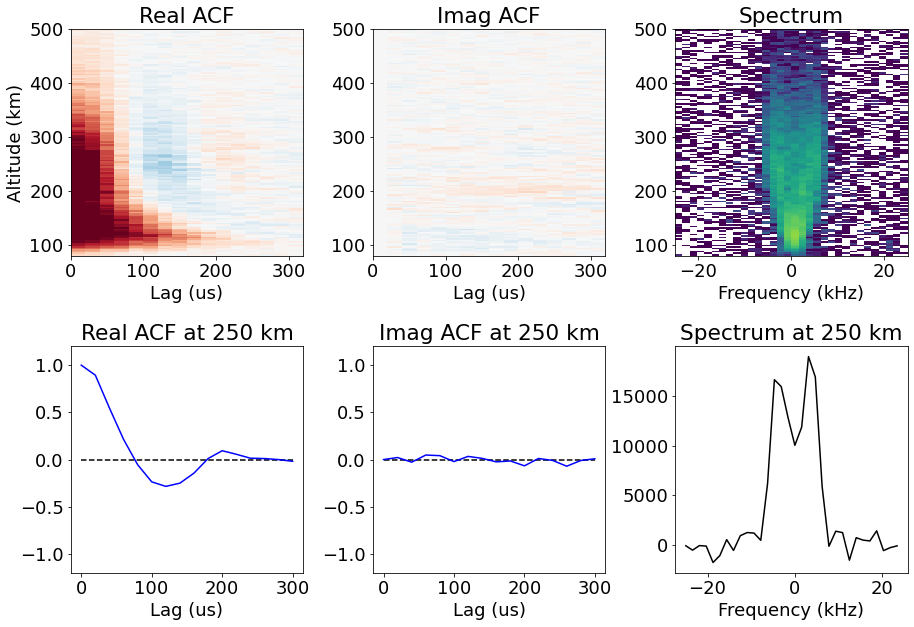

In [13]:
#pick out a cut at a particular altitude
altitude=rng*numpy.sin(numpy.radians(el))
aind=numpy.argmin(numpy.abs(altitude-aplot))

plt.rcParams['figure.figsize']=15,10
plt.rcParams['font.size']=18
fig,axarr=plt.subplots(2,3)
fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.3)
#I strongly recommend setting symmetric color limits so you can clearly see the zero crossings
vmin=-3e3
vmax=3e3
axarr[0,0].pcolormesh(lag,altitude,acf.real.T,vmin=vmin,vmax=vmax,cmap='RdBu_r')
axarr[0,0].set_title('Real ACF')
axarr[0,0].set_xlabel('Lag (us)')
axarr[0,0].set_ylabel('Altitude (km)')
axarr[0,0].set_ylim([80,500])

axarr[0,1].pcolormesh(lag,altitude,acf.imag.T,vmin=vmin,vmax=vmax,cmap='RdBu_r')
axarr[0,1].set_title('Imag ACF')
axarr[0,1].set_xlabel('Lag (us)')
axarr[0,1].set_ylim([80,500])

axarr[0,2].pcolormesh(freq*1e-3,altitude,numpy.log10(spec),vmin=numpy.log10(vmax*32/100.0),vmax=numpy.log10(vmax*32.0),cmap='viridis')
axarr[0,2].set_title('Spectrum')
axarr[0,2].set_xlabel('Frequency (kHz)')
axarr[0,2].set_ylim([80,500])

axarr[1,0].plot(lag[:-1],0.0*acf[:,aind].real/acf[0,aind],'k--')
axarr[1,0].plot(lag[:-1],acf[:,aind].real/acf[0,aind],'b')

axarr[1,0].set_title('Real ACF at %d km'%aplot)
axarr[1,0].set_xlabel('Lag (us)')
axarr[1,0].set_ylim([-1.2,1.2])

axarr[1,1].plot(lag[:-1],0.0*acf[:,aind].real/acf[0,aind],'k--')
axarr[1,1].plot(lag[:-1],acf[:,aind].imag/acf[0,aind],'b')
axarr[1,1].set_title('Imag ACF at %d km'%aplot)
axarr[1,1].set_xlabel('Lag (us)')
axarr[1,1].set_ylim([-1.2,1.2])

axarr[1,2].plot(freq[:-1]*1e-3,spec[aind,:],'k')
axarr[1,2].set_title('Spectrum at %d km'%aplot)
axarr[1,2].set_xlabel('Frequency (kHz)')